In [1]:
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np


%matplotlib inline
userDf = pd.read_csv('processed_user_data.csv')

'''userDf = pd.read_csv('yelp_academic_dataset_user.csv')
#convert string to timestampe
userDf['joined']= pd.to_datetime(userDf['yelping_since'])
#group by year and count occurrences
yearGrouping = userDf.groupby(userDf['joined'].map(lambda x : x.year))['yelping_since'].count()

userDf['number of Friends'] = userDf['friends'].apply( lambda x : len(ast.literal_eval(x)))
userDf['target'] =  userDf['elite']!='[]'
print userDf.dtypes'''


"userDf = pd.read_csv('yelp_academic_dataset_user.csv')\n#convert string to timestampe\nuserDf['joined']= pd.to_datetime(userDf['yelping_since'])\n#group by year and count occurrences\nyearGrouping = userDf.groupby(userDf['joined'].map(lambda x : x.year))['yelping_since'].count()\n\nuserDf['number of Friends'] = userDf['friends'].apply( lambda x : len(ast.literal_eval(x)))\nuserDf['target'] =  userDf['elite']!='[]'\nprint userDf.dtypes"

# Random Forest Classifier
Is it possible to classify users into elite and normal classes? We first tried a random forest classifier to see if learning over a small subset of features produced any promising results. The results are somewhat promising however we noticed something interesting. The ratio of elite users to normal users is about 35,000 to 460,000 users! The dataset is incredibly unbalanced, roughly a ratio of 1:20, meaning that only 5% of all users are labeled elite. This poses a major problem for any flavor of classifier. To illustrate the issue at hand, consider a degenerate classifier that guesses every user is a normal user. What an awful classifier! Unfortunately, applying this classifier will yield an accuracy of about 95%. Sampling techniques such as oversampling and undersampling can combat unbalanced data sets, however scikit's classifiers have a class weight parameter that computes the ratio of classes to one another and assigns a weight according to each classes frequency. Using the correct class weight, we expect that the acccuracy of the classifier will decrease because it will no longer overfit the data by stupidly guessing normal for all cases, thus making the classifier more generalizeable.

In [2]:
import sklearn as sk
print sk.__version__


from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

userDf.fillna(0,inplace=True)

features = ['number of Friends','fans','review_count','fans']
X_train, X_test, Y_train, Y_test =  cross_validation.train_test_split(userDf[features],userDf['target'],train_size=0.8,test_size=0.2)
clf = RandomForestClassifier(class_weight='auto')
clf.fit(X_train,Y_train)
print clf.score(X_test,Y_test)
print clf.predict(X_test)


0.18.1


/Users/PatrickYu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.953835061757
[False False False ..., False False False]


# Using the full data set
Now we are going to consider all the numeric features in our dataset. The classifier is doing some form of over or under sampling so that our class weight is not terribly unbalanced and biased agianst elite users. The accuracy has improved to about 98%, and we have an R-squared value of 0.55 which is acceptable.


In [3]:

features = userDf.select_dtypes(include=[np.number])
cols = [col for col in features.columns if col not in ['Unnamed: 0', 'logstdScore', 'lognormScore','probEliteUser','probNormalUser','score','logScore','customProbEliteUser']]
features = features[cols]
target = userDf['target']
clf = RandomForestClassifier(class_weight='balanced')
numFolds=10
absoluteError=0.0
sqError=0.0
R2 = 0.0
kf = cross_validation.KFold(len(features), n_folds=numFolds, shuffle=True)

for train_index, test_index in kf:
    xTrain, xTest =  features.iloc[train_index], features.iloc[test_index]
    yTrain, yTest = target.iloc[train_index], target.iloc[test_index]
    print 'Epoch Score:',clf.fit(xTrain,yTrain).score(xTest,yTest)
    absoluteError = absoluteError + metrics.mean_absolute_error(yTest, clf.predict(xTest))
    sqError = sqError + metrics.mean_squared_error(yTest, clf.predict(xTest))
    R2 = R2 + metrics.r2_score(yTest,clf.predict(xTest))
print 'Absolute Error:',absoluteError/numFolds
print 'Squared Error:',sqError/numFolds
print 'R2:',R2/numFolds

Epoch Score: 0.977569331158
Epoch Score: 0.97800629224
Epoch Score: 0.97799172687
Epoch Score: 0.976986716383
Epoch Score: 0.977496504311
Epoch Score: 0.977744115591
Epoch Score: 0.978326414682
Epoch Score: 0.97745247979
Epoch Score: 0.977321389556
Epoch Score: 0.977146602578
Absolute Error: 0.022395842684
Squared Error: 0.022395842684
R2: 0.546782063961


## Unbalanced class validation
Because the dataset is unbalanced, we decided to run it against only the elite users to verify that the classifier has not stupifyed itself. Here we get see that the predictive accuracy is about 94% which is good new! This means that the classifier has selected class weights reasonably and also that it has not overfit to the data.

In [4]:
eliteUsers = userDf[userDf['target']==True]
elitefeatures = eliteUsers.select_dtypes(include=[np.number])
elitefeatures = elitefeatures[cols]
#features = features[cols]
#target = userDf['target']
target = eliteUsers['target']
print clf.predict(elitefeatures)
clf.score(elitefeatures,target)

[False  True  True ...,  True  True  True]


0.93566320259246838

In [5]:
print clf.feature_importances_

[ 0.13923249  0.30893338  0.00210412  0.00831697  0.00964822  0.00580112
  0.01373018  0.01492851  0.00159349  0.01935017  0.00320626  0.26140496
  0.00075667  0.15440092  0.00307738  0.00444977  0.03122815  0.01783723]


# Feature Importances
Now that we have a reasonably well-trained and accurate classifier we can look at the imporant features in our classification model and what their impact is on our analysis. Steve McQueen, a.k.a. the king of cool, would be pleased to find that the most important aspect of being an elite user member is that you are cool! Coming in at a whopping 23.2% being cool is the cat's pjyamas, the bee's knees, the... You get the idea. Being cool is fairly meaningful but that is not the only imporant feature users should have. Other featurs are less surprising: review count, number of fans. Surprisingly in this model, the number of fans, and friends did not rank in the top 5 as we believed they were.

Feature ranking:
1.  review_count (0.308933)
2.  votes.cool (0.261405)
3.  votes.funny (0.154401)
4.  compliments.plain (0.139232)
5.  votes.useful (0.031228)
6.  average_stars (0.019350)
7.  number of Friends (0.017837)
8.  compliments.cool (0.014929)
9.  compliments.hot (0.013730)
10.  fans (0.009648)
11.  compliments.writer (0.008317)
12.  compliments.note (0.005801)
13.  compliments.funny (0.004450)
14.  compliments.more (0.003206)
15.  compliments.photos (0.003077)
16.  compliments.cute (0.002104)
17.  compliments.profile (0.001593)
18.  compliments.list (0.000757)


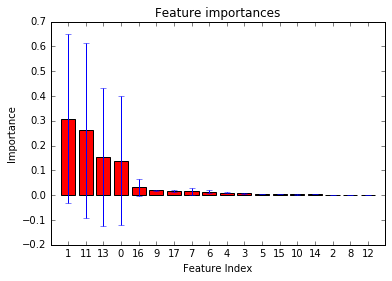

In [6]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features.shape[1]):
    print("%d.  %s (%f)" % (f + 1, features.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.bar(range(features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()

In [7]:
print features.columns
print features.head()

Index([u'compliments.plain', u'review_count', u'compliments.cute',
       u'compliments.writer', u'fans', u'compliments.note', u'compliments.hot',
       u'compliments.cool', u'compliments.profile', u'average_stars',
       u'compliments.more', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful',
       u'number of Friends'],
      dtype='object')
   compliments.plain  review_count  compliments.cute  compliments.writer  \
0               25.0           108              15.0                 9.0   
1              970.0          1292             204.0               346.0   
2               86.0           395              22.0                24.0   
3                0.0            11               2.0                 0.0   
4                2.0            66               2.0                 2.0   

   fans  compliments.note  compliments.hot  compliments.cool  \
0    69              20.0             48.0              76.0 

In [8]:
### Setup for data visualization
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

### You need to create a plotly account.
### Use the username API key  
#plotly.tools.set_credentials_file(username='in99patrick', api_key='Vihz7D87ShjBelThi18E')
plotly.tools.set_credentials_file(username='yu.yuanpeng', api_key='tPOtUdbPgaBabQscZePp')

In [9]:
trace_feature1 = go.Bar(
    x = features.columns[indices],  # input 
    y = importances[indices],       # input 
    error_y=dict(
        type='data',
        array= std[indices],        # input 
        visible=True, 
        color='rgba(184, 188, 219, 1)'),    
    marker=dict(
        color='rgba(30, 160, 70, 0.7)',
        line=dict(color='rgba(30, 160, 70, 1.0)',width=2)),
        
)

data_feature1 = [trace_feature1]
layout = go.Layout(
    title='Feature Importances <BR> Ranked by Random Forest Classifier',
    font=dict(family='Arial', size=18,color='rgb(0, 0, 0)'),
    xaxis=dict(
        title='Star Rating',
        titlefont=dict(
            size=16,
            color='rgb(15, 15, 15)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Importance',
        titlefont=dict(
            size=16,
            color='rgb(15, 15, 15)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    margin=dict(l=40,r=60,b=160,t=100,),
    bargap=0.15,
    annotations = [dict(
            x=xi,
            y=yi,
            text = "{:.2%}".format(yi),
            font=dict(family='Arial', size=12,color='rgba(66, 119, 244, 1)'),
            xanchor='auto',
            yanchor='bottom',
            showarrow=False,
        ) for xi, yi in zip( features.columns[indices], importances[indices] )]  # input 
)

fig_feature1 = go.Figure(data=data_feature1, layout=layout)
py.iplot(fig_feature1, filename='feature_bar_RandomForest')

# ExtraTreesClassifier
The extra trees classifier gave different importances for each feature, but the accuracy for this model is comparable to the random forest classifier. The feature importances of this model were more consistent with the way elite users are elected according to yelp so it was chosen as the preferred model. The most important features, the number of fans, the review count, and the reviews considered useful, matches our intuition about what makes a user elite or popular. Those that publish many useful reviews are likely to have many fans or followers that respect the users opinion giving them credibilty.  

In [10]:
if False:
    from sklearn.ensemble import ExtraTreesClassifier

    features = userDf.select_dtypes(include=[np.number])
    target = userDf['target']
    clf = ExtraTreesClassifier(n_jobs=-1)
    numFolds=10
    absoluteError=0.0
    sqError=0.0
    R2 = 0.0
    kf = cross_validation.KFold(len(features), n_folds=numFolds, shuffle=True)

    for train_index, test_index in kf:
        xTrain, xTest =  features.iloc[train_index], features.iloc[test_index]
        yTrain, yTest = target.iloc[train_index], target.iloc[test_index]
        print 'Epoch Score:',clf.fit(xTrain,yTrain).score(xTest,yTest)
        absoluteError = absoluteError + metrics.mean_absolute_error(yTest, clf.predict(xTest))
        sqError = sqError + metrics.mean_squared_error(yTest, clf.predict(xTest))
        R2 = R2 + metrics.r2_score(yTest,clf.predict(xTest))
    print 'Absolute Error:',absoluteError/numFolds
    print 'Squared Error:',sqError/numFolds
    print 'R2:',R2/numFolds
else:
        print "Are you sure you want to train another classifier over all the data?. A saved classifier is loaded below!"

Are you sure you want to train another classifier over all the data?. A saved classifier is loaded below!


Feature ranking:
1.  fans (0.181519)
2.  review_count (0.113730)
3.  votes.useful (0.097147)
4.  votes.cool (0.096159)
5.  votes.funny (0.072553)
6.  compliments.hot (0.070591)
7.  compliments.cool (0.054360)
8.  compliments.writer (0.051730)
9.  compliments.more (0.051315)
10.  average_stars (0.039921)
11.  number of Friends (0.037733)
12.  compliments.plain (0.034299)
13.  compliments.note (0.024389)
14.  compliments.funny (0.018285)
15.  compliments.cute (0.017926)
16.  compliments.photos (0.016681)
17.  compliments.profile (0.015117)
18.  compliments.list (0.006547)


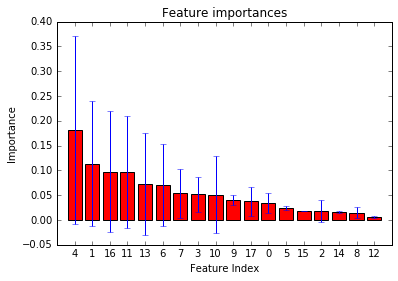

In [11]:
from sklearn.externals import joblib

###### SUPER IMPORTANT ###############
#This loads the classifer that I have saved.
clf = joblib.load('ExtraTreesClassifier_Elite.pkl') 
################# END ###############
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features.shape[1]):
    print("%d.  %s (%f)" % (f + 1, features.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.bar(range(features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()

In [12]:
trace_feature2 = go.Bar(
    x = features.columns[indices],  # input 
    y = importances[indices],       # input 
    error_y=dict(
        type='data',
        array= std[indices],        # input 
        visible=True, 
        color='rgba(184, 188, 219, 1)'),    
    marker=dict(
        color='rgba(244, 191, 66, 0.7)',
        line=dict(color='rgba(244, 191, 66, 1.0)',width=2)),
        
)

data_feature2 = [trace_feature2]
layout = go.Layout(
    title='Feature Importances <BR> Ranked by Extra Trees Classifier',
    font=dict(family='Arial', size=18,color='rgb(0, 0, 0)'),
    xaxis=dict(
        title='Star Rating',
        titlefont=dict(
            size=16,
            color='rgb(15, 15, 15)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Importance',
        titlefont=dict(
            size=16,
            color='rgb(15, 15, 15)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    margin=dict(l=40,r=60,b=160,t=100,),
    bargap=0.15,
    annotations = [dict(
            x=xi,
            y=yi,
            text = "{:.2%}".format(yi),
            font=dict(family='Arial', size=12,color='rgba(66, 119, 244, 1)'),
            xanchor='auto',
            yanchor='bottom',
            showarrow=False,
        ) for xi, yi in zip( features.columns[indices], importances[indices] )]  # input 
)

fig_feature2 = go.Figure(data=data_feature2, layout=layout)
py.iplot(fig_feature2, filename='feature_bar_ExtraTreesClassifier')

# TPOT
Mannn... I need a super computer to run this. The runtime on this data set is probably hours?!

In [13]:
'''X_train, X_test, Y_train, Y_test =  train_test_split(features,userDf['target'],train_size=0.8,test_size=0.2)

tpot = TPOTClassifier(generations=5, population_size=20,verbosity=2)
tpot.fit(X_train, Y_train)
print tpot.score(X_test,Y_test)'''

"X_train, X_test, Y_train, Y_test =  train_test_split(features,userDf['target'],train_size=0.8,test_size=0.2)\n\ntpot = TPOTClassifier(generations=5, population_size=20,verbosity=2)\ntpot.fit(X_train, Y_train)\nprint tpot.score(X_test,Y_test)"

# Creating a measure of Elitism
Using the feature importances from the classifier we decided to delve deeper into creating a score for the reliability or credibility of the user. The score is calculated by vectorizing the classifier weights, and the numeric features for each user, and computing the inner product. This produces a linear metric based on the values of the important features and each user that we will investigate further. 

In [14]:
#make dictionary of feature importances
sample = userDf.iloc[0:5,:]
#print sample
factors = dict()
for f in range(features.shape[1]):
    factors[features.columns[indices[f]]] = importances[indices[f]]
#print factors.keys()
#print type(factors.keys())
#print factors.values()

#define a function to calculate the score from the important features. The score a metric to see 'how elite' a user is.
def getEliteScore(x):
    return x[factors.keys()].dot(factors.values())

#fill missing values with 0.
userDf.fillna(0,inplace=True)

#TEST
#sample['score']=sample.apply(lambda x : getEliteScore(x),axis=1)
#print sample['score']

#Add elite metric to data frame column 'score'.
userDf['score']=userDf.apply(lambda x : getEliteScore(x),axis=1)

# How close are you to being worthy of the elite class?

To measure how far away a user is from being elite, we first need to determine the score cuttoff for elitism. We could take the absolute minimum, median, mean, or a more advanced measure to determine the liklihood that a user is eilte or near the threshold. One idea is to try and fit a distribution to the scores of elite users and see if they also follow a normal distribution. This would allow for a probability of being elite to be calculated for all users not just the elite ones!

Again the way the scores are distributed among the elite users is frustrating! It looks almost like a normal or a skew normal distribution but a number of outliers are causing the distributino

Elite user stats
count    35796.000000
mean       167.647958
std        448.877419
min          1.626000
25%         35.908576
50%         69.764015
75%        146.111220
max      20826.351833
Name: score, dtype: float64
non-Elite user stats
count    650760.000000
mean          4.519369
std          28.169025
min           0.000000
25%           0.579192
50%           1.355341
75%           3.867790
max       17643.735934
Name: score, dtype: float64
All user stats
count    686556.000000
mean         13.024649
std         112.126695
min           0.000000
25%           0.611350
50%           1.497447
75%           4.815205
max       20826.351833
Name: score, dtype: float64


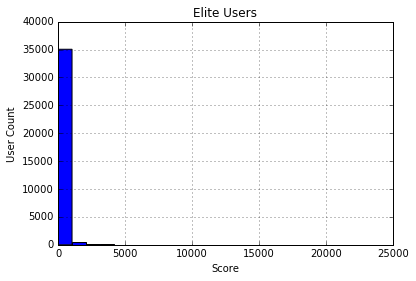

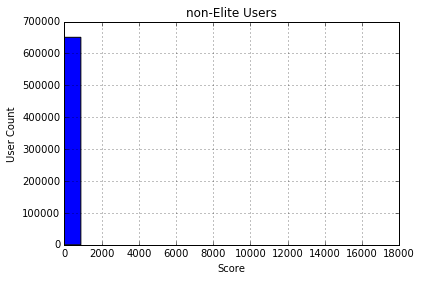

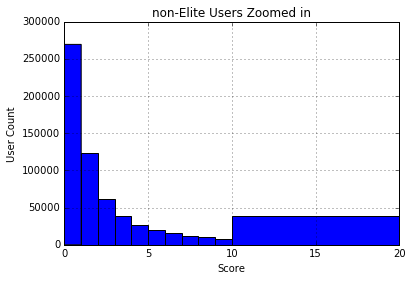

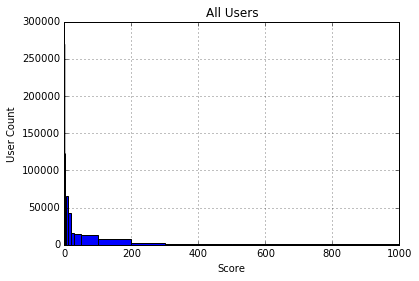

In [15]:
#userDf.to_csv('updated_users.csv')
#data frame of elite users
eliteUsers = userDf[userDf['target']==True]
#data fram of normal users
normUsers = userDf[userDf['target']==False]
print "Elite user stats"
print eliteUsers['score'].describe()

print "non-Elite user stats"
print normUsers['score'].describe()

print "All user stats"
print userDf['score'].describe()
#eliteUsers.sort_values('score',ascending=True)

#Create uneven bins to help visualize histogram
bins = [0,1,2,3,4,5,10,20,30,50,100,200,300,400,500,1000]
#smaller scale for normal users
bins2 = [0,1,2,3,4,5,6,7,8,9,10,20]

plt.figure()
plt.title('Elite Users')
plt.xlabel("Score")
plt.ylabel("User Count")
eliteUsers['score'].hist(bins=20)
           
plt.figure()
plt.title('non-Elite Users')
plt.xlabel("Score")
plt.ylabel("User Count")
normUsers['score'].hist(bins=20)
           
plt.figure()
plt.title('non-Elite Users Zoomed in')
plt.xlabel("Score")
plt.ylabel("User Count")
normUsers['score'].hist(bins=bins2)
           
plt.figure()
plt.title('All Users')
plt.xlabel("Score")
plt.ylabel("User Count")
userDf['score'].hist(bins=bins)

In [16]:
eliteScores = eliteUsers[['score']]

#print eliteScores
print eliteScores['score'].mean()
print eliteScores['score'].median()
print eliteScores['score'].max()
print eliteScores['score'].min()
std = eliteScores['score'].std()
print 'Std. Deviation: ',std
print 'Outlier Cuttoff: ',std*3
#print eliteScores[eliteScores['score'] > std*3]

############### SUPER IMPORTANT !!!!!!!!! ##########
#This forces the outliers to equal 3 times the std. deviation. (around 1200)
eliteScores['score'].clip(0,3*std)
##################################################

#Standardize scores to [0,1]
eliteScores['stdScore'] = eliteScores['score'].apply(lambda x : ( x - eliteScores['score'].min() ) / ( eliteScores['score'].max()-eliteScores['score'].min()))
#normalize scores. potentially creates negative values.
eliteScores['normScore'] = eliteScores['score'].apply(lambda x : ( x - eliteScores['score'].mean() ) / ( eliteScores['score'].max()-eliteScores['score'].min()))

167.647957538
69.7640150635
20826.3518335
1.62600029341
Std. Deviation:  448.877418988
Outlier Cuttoff:  1346.63225696


count    35796.000000
mean         0.007972
std          0.021555
min          0.000000
25%          0.001646
50%          0.003272
75%          0.006938
max          1.000000
Name: stdScore, dtype: float64
count    3.579600e+04
mean    -3.545473e-17
std      2.155502e-02
min     -7.972348e-03
25%     -6.326104e-03
50%     -4.700371e-03
75%     -1.034191e-03
max      9.920277e-01
Name: normScore, dtype: float64
count    35796.000000
mean         4.362510
std          1.083002
min          0.965462
25%          3.608444
50%          4.259351
75%          4.991189
max          9.944022
Name: logScore, dtype: float64
count    686556.000000
mean          1.301371
std           1.138557
min           0.000000
25%           0.477073
50%           0.915269
75%           1.760476
max           9.944022
Name: logScore, dtype: float64


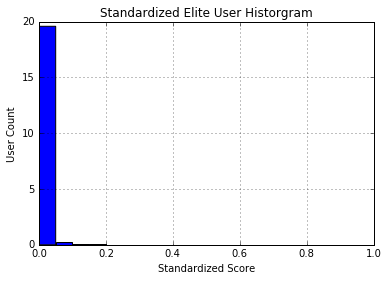

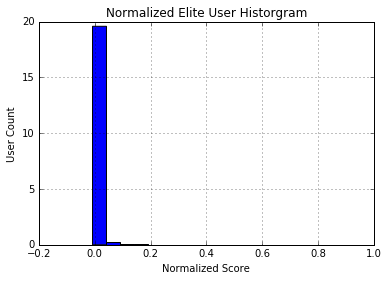

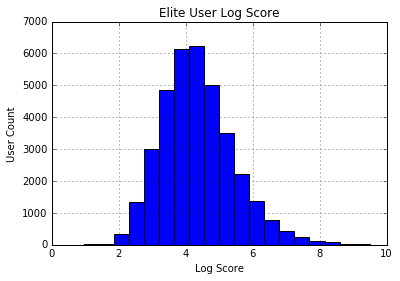

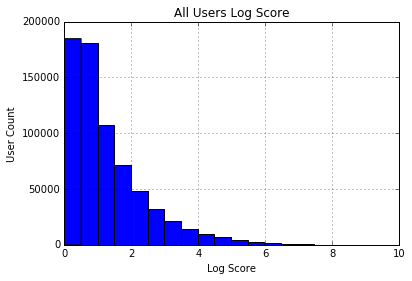

In [17]:
#the log function adds 1 to the score before taking the log because log(0) = undefined
def adjLog(x):
    return np.log(x+1)

eliteScores['logScore'] =  eliteScores['score'].apply(adjLog)
userDf['logScore'] = userDf['score'].apply(adjLog)
print eliteScores['stdScore'].describe()
print eliteScores['normScore'].describe()
print eliteScores['logScore'].describe()
print userDf['logScore'].describe()

plt.figure()
plt.title('Standardized Elite User Historgram')
plt.xlabel("Standardized Score")
plt.ylabel("User Count")
eliteScores['stdScore'].hist(bins=20,normed=True)

plt.figure()
plt.title('Normalized Elite User Historgram')
plt.xlabel("Normalized Score")
plt.ylabel("User Count")
eliteScores['normScore'].hist(bins=20,normed=True)

plt.figure()
plt.title('Elite User Log Score')
plt.xlabel("Log Score")
plt.ylabel("User Count")           
eliteScores['logScore'].hist(bins=20)

plt.figure()
plt.title('All Users Log Score')
plt.xlabel("Log Score")
plt.ylabel("User Count")            
userDf['logScore'].hist(bins=20)

NormaltestResult(statistic=2535.6385139026079, pvalue=0.0)
SkewtestResult(statistic=45.643622950215665, pvalue=0.0)


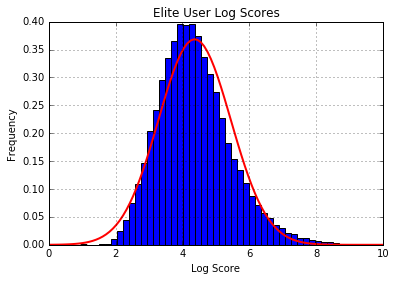

In [27]:
import scipy.stats as stats
from scipy.stats import skewnorm
import matplotlib.mlab as mlab

#print eliteScores['logScore']
print stats.normaltest(eliteScores['logScore'])
print stats.skewtest(eliteScores['logScore'])

eliteScores['logScore'].hist(bins=50,normed=1)
mu = eliteScores['logScore'].mean()
sigma = eliteScores['logScore'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
plt.title('Elite User Log Scores')
plt.xlabel("Log Score")
plt.ylabel("Frequency")    

In [19]:
#Standardize log score
eliteScores['logstdScore'] = eliteScores['logScore'].apply(lambda x : ( x - eliteScores['logScore'].min() ) / ( eliteScores['logScore'].max()-eliteScores['logScore'].min()))

#Normalize log score
eliteScores['lognormScore'] = eliteScores['logScore'].apply(lambda x : ( x - eliteScores['logScore'].mean() ) / ( eliteScores['logScore'].max()-eliteScores['logScore'].min()))

count    35796.000000
mean         0.378351
std          0.120621
min          0.000000
25%          0.294366
50%          0.366862
75%          0.448371
max          1.000000
Name: logstdScore, dtype: float64
count    3.579600e+04
mean     4.063487e-15
std      1.206209e-01
min     -3.783511e-01
25%     -8.398523e-02
50%     -1.148957e-02
75%      7.001996e-02
max      6.216489e-01
Name: lognormScore, dtype: float64


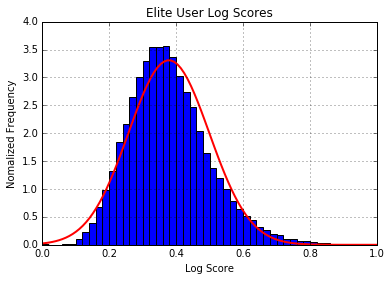

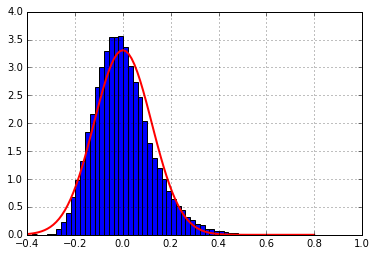

In [29]:
print eliteScores['logstdScore'].describe()
print eliteScores['lognormScore'].describe()

plt.figure()
eliteScores['logstdScore'].hist(bins=50,normed=1)
mu = eliteScores['logstdScore'].mean()
sigma = eliteScores['logstdScore'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
plt.title('Elite User Log Scores')
plt.xlabel("Log Score")
plt.ylabel("Nomalized Frequency")  

plt.figure()
eliteScores['lognormScore'].hist(bins=50,normed=1)
mu = eliteScores['lognormScore'].mean()
sigma = eliteScores['lognormScore'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)


In [21]:
#First column is probability of non-elite. Second column is prob of elite.
#Create dataframe column with probabilities from the classifier.
userDf['probNormalUser'] =  clf.predict_proba(features)[:,0]
userDf['probEliteUser'] = clf.predict_proba(features)[:,1]

NormaltestResult(statistic=2535.6385139026079, pvalue=0.0)
NormaltestResult(statistic=2535.6385139026129, pvalue=0.0)


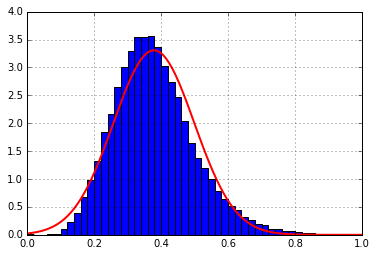

In [22]:
print stats.normaltest(eliteScores['lognormScore'])
print stats.normaltest(eliteScores['logstdScore'])
mu, sigma =  stats.norm.fit(eliteScores['logstdScore'])
plt.figure()
eliteScores['logstdScore'].hist(bins=50,normed=1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)

scoreDist = stats.norm(mu, sigma)


In [23]:
usermin = userDf['logScore'].min()
usermax = userDf['logScore'].max()
usermean = userDf['logScore'].mean()


userDf['logstdScore'] = userDf['logScore'].apply(lambda x : ( x - usermin ) / ( usermax-usermin))
userDf['lognormScore'] = userDf['logScore'].apply(lambda x : ( x - usermean ) / ( usermax-usermin))

userDf['customProbEliteUser'] = userDf['logstdScore'].apply(scoreDist.cdf)
print userDf['customProbEliteUser'] 

0         0.776093
1         0.999920
2         0.960051
3         0.031233
4         0.207606
5         0.999973
6         0.268578
7         0.355069
8         0.562010
9         0.003064
10        0.090401
11        0.989181
12        0.249407
13        0.315427
14        0.046753
15        0.004390
16        0.020422
17        0.076945
18        0.038285
19        0.001274
20        0.001862
21        0.034053
22        0.200461
23        0.037352
24        0.004357
25        0.005460
26        0.033636
27        0.056989
28        0.024703
29        0.010858
            ...   
686526    0.011384
686527    0.015569
686528    0.002186
686529    0.004283
686530    0.004227
686531    0.002254
686532    0.003596
686533    0.002326
686534    0.001788
686535    0.004611
686536    0.003011
686537    0.004160
686538    0.004409
686539    0.004188
686540    0.002844
686541    0.020061
686542    0.021324
686543    0.025333
686544    0.002595
686545    0.012217
686546    0.003949
686547    0.

In [24]:
#userDf.to_csv('processed_user_data.csv')

# Model Persistence
I'm tired of getting a new model everytime and I'm too lazy to find a classifier that converges to the same model. This saves the classifier that I ran and normalized the score for. The cell below shows how to save a model and the commented section shows how to load the model from the pickle(.pkl) file.

In [25]:
import pickle
from sklearn.externals import joblib

#s = pickle.dumps(clf)
#joblib.dump(clf, 'ExtraTreesClassifier_Elite.pkl') 

#Use this to load the classifier.
#clf = joblib.load('ExtraTreesClassifier_Elite.pkl') 